<a href="https://colab.research.google.com/github/rohinikanth/RAG/blob/main/RAG_with_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --user transformers datasets torch faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 15.7 MB/s eta 0:00:00


In [2]:
!pip install --user matplotlib scikit-learn

In [3]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.7.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.1
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.6.2.0.38

In [3]:
from transformers import DPRContextEncoder,DPRContextEncoderTokenizer
import torch
import numpy as np
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer,AutoModelForCausalLM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE



In [4]:
def plots(data):
    #t-SNE (t-Distributed Stochastic Neighbor Embedding) is an effective method for visualizing high-dimensional data
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))

    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])

    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

In [5]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.1 MB/s eta 0:00:00


In [8]:
#Load data
filename = 's41598-021-03585-1.pdf'

import PyPDF2
import re

def read_and_split_text(filename,sentences_per_paragraph=10):
    with open(filename, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page in reader.pages:
            page_text = page.extract_text()
            if page_text:
                page_text = page_text.replace('-\n', '')  # Fix hyphenated words
                page_text = page_text.replace('\n', ' ')  # Remove line breaks
                text += page_text + ' '

    # Split into paragraphs at sentence boundaries
    sentences = re.split(r'(?<=[.?!])\s+(?=[A-Z])', text)
    sentences = [sent.strip() for sent in sentences if len(sent.strip()) > 80]
    paragraphs = [
        ' '.join(sentences[i:i + sentences_per_paragraph])
        for i in range(0, len(sentences), sentences_per_paragraph)
    ]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('s41598-021-03585-1.pdf')

In [9]:
paragraphs[30:40]

['CATENA   188, 104451. https://  doi. org/ 10. 1016/j.  catena.  2019. 104451  (2020).  46. A deep learning algorithm using a fully connected sparse autoencoder neural network for landslide susceptibility  prediction. Landslides  17, 217–229. https://  doi. org/ 10. 1007/  s10346-  019-  01274-9  (2020). 16 Vol:.(1234567890) Scientific Reports  |        (2021) 11:24112  | https://doi.org/10.1038/s41598-021-03585-1 www.nature.com/scientificreports/ 47. Comparing the prediction performance of a Deep Learning  Neural Network model with conventional machine learning models in landslide susceptibility assessment. CATENA 188, 104426.  https://  doi. org/ 10. 1016/j.  catena.  2019. 104426  (2020).  48. Comparison of deep neural networks to spatio-temporal cortical  dynamics of human visual object recognition reveals hierarchical correspondence. Mapping landslides on EO data: Performance of deep learning models vs traditional machine  learning models. Geosciences   11, 226. https://  doi. or

In [10]:
for i in range(0,5):
  print(f"sample: {i} paragraph: {paragraphs[i]}\n")

sample: 0 paragraph: 1 Vol.:(0123456789) Scientific Reports  |        (2021) 11:24112  | https://doi.org/10.1038/s41598-021-03585-1 www.nature.com/scientificreportsDeep learning‑based landslide  susceptibility mapping Mohammad Azarafza1, Mehdi Azarafza2, Haluk Akgün3, Peter M. Atkinson4 &  Reza Derakhshani5,6* Landslides are considered as one of the most devastating natural hazards in Iran, causing extensive  damage and loss of life. Landslide susceptibility maps for landslide prone areas can be used to plan  for and mitigate the consequences of catastrophic landsliding events. Here, we developed a deep  convolutional neural network (CNN–DNN) for mapping landslide susceptibility, and evaluated it on  the Isfahan province, Iran, which has not previously been assessed on such a scale. The proposed  model was trained and validated using training (80%) and testing (20%) datasets, each containing  relevant data on historical landslides, field records and remote sensing images, and a range o

In [11]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [12]:
#Checking ContextEncoder tokenizer
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [13]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


In [14]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
import random
random.shuffle(paragraphs)
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.0186, -0.2280, -0.1975,  ..., -0.5991,  0.0656,  0.1840],
        [-0.4326, -0.1931,  0.2416,  ..., -0.4096, -0.5322, -0.2121],
        [-0.2225,  0.0305,  0.2697,  ..., -0.5890, -0.2380, -0.3442],
        ...,
        [-0.3200, -0.1979,  0.4361,  ..., -0.5568, -0.1062, -0.1969],
        [-0.2813, -0.4396,  0.3296,  ..., -0.4239,  0.0183,  0.1458],
        [ 0.0783, -0.3888,  0.1520,  ..., -0.5325,  0.1345, -0.2153]],
       grad_fn=<SliceBackward0>)

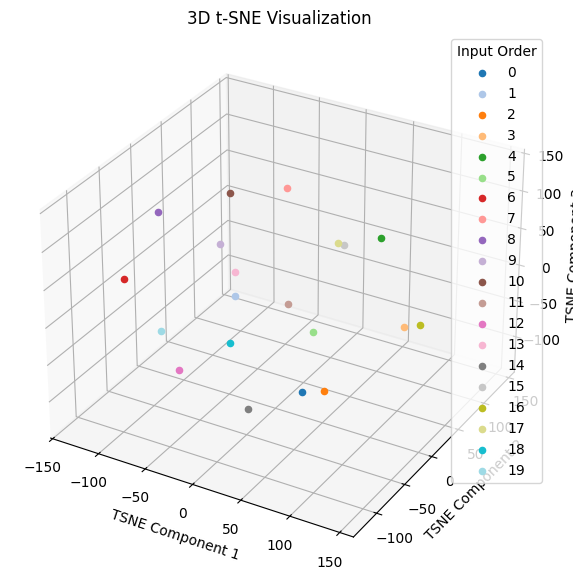

In [16]:
plots(outputs.pooler_output.detach().numpy())

In [35]:
print("sample 5:", paragraphs[16])
print("sample 18:", paragraphs[18])

print("sample 10:", paragraphs[10])
print("sample 2:", paragraphs[2])

sample 5: The performance matrix is a specific table that visualises the performance of a  prediction algorithm based on its predicted values, and it contains the sensitivity, specificity and 1-specificity  parameters. For classification tasks, true positives (TP), true negatives (TN), false positives (FP) and false negatives (FN) are used to compare the results of the classifier in question with trusted external judgments (Hearty  2016). Precision, also called the positive predictive value, is the fraction of relevant instances (TP) amongst the  retrieved instances. The environmental factors used in the analysis: (a ) climate, (b ) watershed, (c ) drainage pattern, (d )  vegetation using ArcGIS 10.4.1 software  package55. The human-activity related factors used in the analysis: (a ) distance to roads, (b ) distance to cities  using ArcGIS 10.4.1 software  package55. 8 Vol:.(1234567890) Scientific Reports  |        (2021) 11:24112  | https://doi.org/10.1038/s41598-021-03585-1 www.natur

samples discuss diversity. Rather than relying solely on visual inspection, distances between embeddings are employed to determine the relevance of retrieved documents or passages. This involves comparing the query’s embedding with the embeddings of candidate documents, enabling a precise and objective measure of relevance.

In [17]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


In [18]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

In [19]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

In [20]:
context_embeddings

array([[ 0.01861554, -0.22802065, -0.19754633, ..., -0.5991322 ,
         0.06562608,  0.18395303],
       [-0.4325573 , -0.19312814,  0.2415763 , ..., -0.40960002,
        -0.53219175, -0.21213725],
       [-0.22250617,  0.0305414 ,  0.26971427, ..., -0.5890117 ,
        -0.23796102, -0.34424615],
       ...,
       [ 0.10424465, -0.08504135,  0.48281628, ..., -0.6553708 ,
        -0.07504836, -0.02962995],
       [-0.42748326,  0.10887129,  0.02349153, ...,  0.02088128,
        -0.1006383 , -0.14685598],
       [-0.12530555, -0.10445824, -0.23303817, ..., -0.7003903 ,
        -0.06033783, -0.10743633]], dtype=float32)

In [22]:
!pip install faiss-cpu


In [26]:
'''import faiss
import numpy as np

embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index'''

import numpy as np
from sklearn.neighbors import NearestNeighbors

embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a NearestNeighbors "index" similar to FAISS
index = NearestNeighbors(n_neighbors=5, metric='euclidean')  # or 'cosine'
index.fit(context_embeddings_np)

# Add a query to test
query_embedding = np.random.rand(1, embedding_dim).astype('float32')
distances, indices = index.kneighbors(query_embedding)

print("Indices of closest matches:", indices)
print("Distances:", distances)


Indices of closest matches: [[20 30  3 17 18]]
Distances: [[20.25853157 20.29398155 20.3152504  20.34446716 20.35280991]]


In [27]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
# Example question
question = 'Conclusions'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
distances, indices = index.kneighbors(question_embedding, n_neighbors=5)  # Retrieve top 5

print("Distances:", distances)
print("Indices:", indices)

Distances: [[10.01478672 10.36922169 10.70409584 10.71173382 10.76185226]]
Indices: [[17 30 18 23  3]]


In [39]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(indices[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {distances[0][i]}\n")

Top 5 relevant contexts:
1: Conclusions Landslide susceptibility mapping is one of the most challenging tasks in geo-hazard assessment. In this context,  application of modern deep learning techniques can be advantageous for analysis. Here, we applied a novel  CNN–DNN predictive model for assessment of landslide susceptibility in Isfahan province, Iran. The model was  fitted between historical landslides data (which accounted for different types of landsliding) and various triggering  factors. The proposed CNN–DNN model produced a very high accuracy, outperforming a wide range of benchmark approaches, specifically the SVM, LR, GNB, MLP , BNB and DT methods. More specifically, the CNN–DNN  (AUC  = 90.9%; IRs  = 84.8%) achieved greater prediction accuracy than the corresponding single classifiers such  as SVM (AUC = 81.5%; IRs = 80.1%), LR (AUC = 78.3%; IRs = 72.2%), GNB (AUC = 80.1%; IRs = 68.7%), BNB  (AUC  = 50.0%; IRs  = 61.0%), MLP (AUC = 50.9%; IRs  = 61.8%) and DT (AUC  = 85.5%; I

In [40]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
  question_inputs = question_tokenizer(question, return_tensors='pt')
  question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()
  distances, indices = index.kneighbors(question_embedding, n_neighbors=10)
  return indices, distances


In [56]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

# Ensure pad_token exists (GPT2 doesn't have it by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Resize model embeddings if new tokens were added
model.resize_token_embeddings(len(tokenizer))

# Set generation config pad_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id


In [57]:
print(model.config._name_or_path)

openai-community/gpt2


In [58]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)

    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

In [59]:
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


In [60]:
question = "What is the architecture used in this model?Explain"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it works.

What is the architecture used in this model?Explain what the architecture is and how it


In [69]:
def generate_answer(question, contexts):
    # Concatenate and trim the context to a manageable length
    input_context = ' '.join(contexts)
    max_context_length = 1800  # adjust to stay under model token limit
    input_context = input_context[:max_context_length]

    # Combine question and context
    input_text = question + ' ' + input_context

    # Tokenize with truncation to prevent input overflow
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        truncation=True,
        max_length=1024,
        padding='max_length'
    )

    # Generate output
    output_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=100,
        do_sample=False,
        min_length=40,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,
        #temperature=0.7,
        #top_k=3,
        #top_p=0.95,
        pad_token_id=tokenizer.pad_token_id
    )

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Extract only the generated part after "Answer:"
    if "Answer:" in output_text:
        return output_text.split("Answer:")[-1].strip()
    else:
        return output_text.strip()

In [70]:
_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

top_contexts = [paragraphs[int(idx)] for idx in I[0]]
print(f"top_contexts {top_contexts}")
question = "What is the architecture used in this model?Explain"

answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

paragraphs indexs [[10.18331432 10.20766449 10.26643848 10.39528656 10.39799404 10.4692688
  10.56363964 10.5746479  10.61281109 10.64727497]]
top_contexts ['Since spatial prediction (i.e., mapping) is crucial  for a range of applications including crisis management, urban planning and geo-hazard assessment (including  landslide susceptibility assessment), the coupled CNN and DNN classifier has found wide  applicability8,37,42,49. In the CNN–DNN classifier, the input data are evaluated by convolution, pooling, batch normalisation, dense,  dropout and fully connected layers to predict the outputs (Fig.\xa0 1). The input data provide the first layer of evaluation as a data matrix in which each  element has a specific feature value. Hence, the input layer is the primary feature map modified and organised  by each convolutional layer and unit. The first convolutional layer extracts some low-level features (e.g., lines, edges, corners). Further convolutional layers learn  iteratively more i

IndexError: index out of range in self